In [1]:
import os
import torch
from torch.utils.data import DataLoader
from model_paired_ae_emma import MultimodalAE, Encoder, Decoder
# from src.dataset import generate_datasets, concat_datasets
from src.dataset_2 import generate_datasets
import torch.nn as nn

In [2]:
# concat_datasets(root_dir='./data', suffix='diff')

### Data

In [2]:
# Generate datasets
train_datasets = generate_datasets(suffix='3_clusters', type='paired', train=True, test=False)
test_datasets = generate_datasets(suffix='3_clusters', type='paired', train=False, test=True)


# Create dataloaders
train_loaders = [DataLoader(dataset, batch_size=32, shuffle=True) for dataset in train_datasets]
test_loaders = [DataLoader(dataset, batch_size=32, shuffle=False) for dataset in test_datasets]

Loading train paired dataset
Loading test paired dataset
Scaler saved
Loading train paired dataset
Loading test paired dataset
Scaler saved
131 367 160


# MODEL 1

### Model initialization

In [3]:
# Model dimensions
n_inputs1 = train_datasets[0][0][0].shape[0]  
n_inputs2 = train_datasets[1][0][0].shape[0]  
n_inputs3 = train_datasets[2][0][0].shape[0] 
latent_dims = 20   
n_hiddens = 256

# Create the model
encoder1 = Encoder(n_inputs1, latent_dims, n_hiddens)
encoder2 = Encoder(n_inputs2, latent_dims, n_hiddens)
encoder3 = Encoder(n_inputs3, latent_dims, n_hiddens)

decoder1 = Decoder(n_inputs1, latent_dims, n_hiddens)
decoder2 = Decoder(n_inputs2, latent_dims, n_hiddens)
decoder3 = Decoder(n_inputs3, latent_dims, n_hiddens)

model1 = MultimodalAE(encoder=encoder1, decoder=decoder1)
model2 = MultimodalAE(encoder=encoder2, decoder=decoder2)
model1_2 = MultimodalAE(encoder=encoder1, decoder=decoder2)
model2_1 = MultimodalAE(encoder=encoder2, decoder=decoder1)
model3 = MultimodalAE(encoder=encoder3, decoder=decoder3)
model1_3 = MultimodalAE(encoder=encoder1, decoder=decoder3)
model3_1 = MultimodalAE(encoder=encoder3, decoder=decoder1)
model2_3 = MultimodalAE(encoder=encoder2, decoder=decoder3)
model3_2 = MultimodalAE(encoder=encoder3, decoder=decoder2)

### Criteria and optimizer

In [5]:
critere = nn.MSELoss()
lr = 0.00001
optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)
optimizer1_2 = torch.optim.Adam(model1_2.parameters(), lr=lr)
optimizer2_1 = torch.optim.Adam(model2_1.parameters(), lr=lr)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=lr)
optimizer1_3 = torch.optim.Adam(model1_3.parameters(), lr=lr)
optimizer3_1 = torch.optim.Adam(model3_1.parameters(), lr=lr)

### Train

In [6]:
num_epochs = 100
batch_size = 32
list1_1 = []
list3_3 = []
list1_3 = []
list3_1 = []

for epoch in range(num_epochs):
    model1.train()
    model3.train()
    model1_3.train()
    model3_1.train()
    
    for i, ((x1, _), (x2, _), (x3, y)) in enumerate(zip(*train_loaders)):
        if x1.size(0) != batch_size or x3.size(0) != batch_size or y.size(0) != batch_size:
            continue

        # Forward pass
        o1, o3, o1_3, o3_1 = model1(x1), model3(x3), model1_3(x1), model3_1(x3)
        loss1_1, loss3_3, loss1_3, loss3_1 = critere(o1, x1), critere(o3, x3), critere(o1_3, x3), critere(o3_1, x1)
        # loss1_1, loss3_3, loss1_3, loss3_1 = critere(o1, o1), critere(o3, o3), critere(o1_3, o3), critere(o3_1, o1)
        
        # Compute total loss
        loss = loss1_1 + loss3_3 + loss1_3 + loss3_1

        # Backward and optimize
        optimizer1.zero_grad()
        optimizer3.zero_grad()
        optimizer1_3.zero_grad()
        optimizer3_1.zero_grad()
        loss.backward()
        optimizer1.step()
        optimizer3.step()
        optimizer1_3.step()
        optimizer3_1.step()

    list1_1.append(loss1_1.item())
    list3_3.append(loss3_3.item())
    list1_3.append(loss1_3.item())
    list3_1.append(loss3_1.item())
    
    # Print epoch-wise losses
    print(f'Epoch {epoch + 1} -> Total Loss: {loss:.4f}')

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Epoch 1 -> Total Loss: 1.1732
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<cla

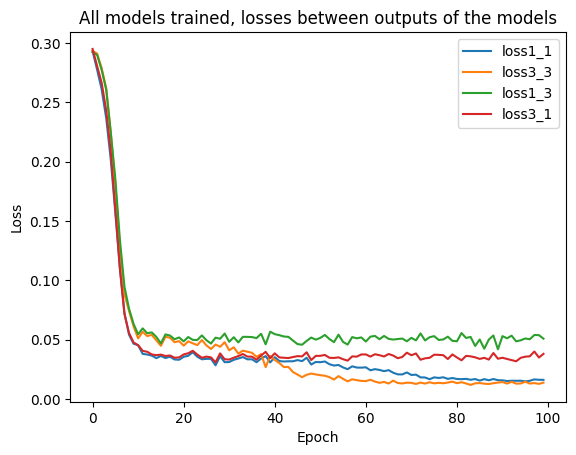

In [7]:
import matplotlib.pyplot as plt

plt.plot(list1_1, label='loss1_1')
plt.plot(list3_3, label='loss3_3')
plt.plot(list1_3, label='loss1_3')
plt.plot(list3_1, label='loss3_1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('All models trained, losses between outputs of the models')
plt.legend()

### Test

In [8]:
model1.eval()
model3.eval()
model1_3.eval()
model3_1.eval()

with torch.no_grad():
    total_loss = 0
    for (x1, _), (x2, _), (x3, y) in zip(*test_loaders):
        o1, o3, o1_3, o3_1 = model1(x1), model3(x3), model1_3(x1), model3_1(x3)
        loss = critere(o1, x1) + critere(o3, x3) + critere(o1_3, x3) + critere(o3_1, x1)
        total_loss += loss.item()
    print(f'Test Loss: {total_loss / len(test_loaders[0])}')
    print(" loss1 :", critere(o1, x1).item(), " loss3 :", critere(o3, x3).item(), " loss1_3 :", critere(o1_3, x3).item(), " loss3_1 :", critere(o3_1, x1).item())

Test Loss: 0.11382882048686345
 loss1 : 0.01702406257390976  loss3 : 0.013006061315536499  loss1_3 : 0.049019549041986465  loss3_1 : 0.03600035235285759


# MODEL 2

### Model initialization

In [3]:
encoder1_new = Encoder(n_inputs3, latent_dims, n_hiddens)
encoder3_new = Encoder(n_inputs3, latent_dims, n_hiddens)

decoder1_new = decoder1
for param in decoder1_new.parameters():
    param.requires_grad = False

model1_new = MultimodalAE(encoder=encoder1_new, decoder=decoder1_new)
model3_1_new = MultimodalAE(encoder=encoder3_new, decoder=decoder1_new)

### Criteria and optimizers

In [9]:
critere = nn.MSELoss()
lr = 0.0001
optimizer1_new = torch.optim.Adam(model1_new.encoder.parameters(), lr=lr)
optimizer3_1_new = torch.optim.Adam(model3_1_new.encoder.parameters(), lr=lr)

In [1]:
num_epochs = 100
batch_size = 32
list1_1_new = []
list3_1_new = []

for epoch in range(num_epochs):
    model1_new.train()
    model3_1_new.train()

    
    for i, ((x1, _), (x2, _), (x3, y)) in enumerate(zip(*train_loaders)):
        if x1.size(0) != batch_size or x3.size(0) != batch_size or y.size(0) != batch_size:
            continue
        
        # Forward pass
        o1 =  model1_new(x1)
        o3_1 = model3_1_new(x3)
        print(len(o1), len(o3_1), len(x1), len(x3))
        loss1_1, loss3_1 = critere(o1, x1), critere(o3_1, x1)
        
        # Compute total loss
        loss = loss1_1 + loss3_1
        
        # Backward and optimize
        optimizer1_new.zero_grad()
        optimizer3_1_new.zero_grad()
        loss.backward()
        optimizer1_new.step()
        optimizer3_1_new.step()

    list1_1_new.append(loss1_1.item())
    list3_1_new.append(loss3_1.item())
    

In [ ]:
plt.plot(list1_1_new, label='loss1_1')
plt.plot(list3_1_new, label='loss3_1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('New proposition : Encoder 1 pretrained, encoder 1 and 3 trained and Decoder 1 frozen')
plt.legend()